To compare item similarity metrics/pipelines, we have previously used Pearson correlation on flatten matrices of estimated item similarities. Depending on the usage of the item similarity computation, other metrics could be more suitable. For recommendation, for example, we only care about a small neighborhood of a given item, i.e. the most similar items. The particular values or order of very disimilar item is not important in this case. So if we use item similarities for recommendation, a ranking metric, such as agreement on top 5 most similar items, is more appropriate to compare differences between pipelines. In this notebook, we study if the choice of this *pipeline-similarity* metric is important.

Expectation: it is important whether we use metric looking at all similarites (such as Pearson correlation) or just the head of the list (ranking metrics), but the choice of specific metric (e.g. Pearson vs Spearman) or metric parameters (e.g. k in top-k-agreement) does not lead to fundamentally different results.

In [1]:
from collections import Counter, OrderedDict
from functools import partial
from itertools import product
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

In [2]:
# ad-hoc imports
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.adjust_text import adjust_text

In [3]:
# load data (hack)
sys.path.append(os.path.abspath(os.path.join('..', 'data', 'robomission')))
from tasks_2017_09_25 import tasks

In [4]:
# helper functions

def get_letters(task):
    """Return all letters (= objects) in the setting of a task"""
    letters = Counter()
    fields = task.setting['fields']
    for row in fields:
        for _background, objects in row:
            letters.update(canonize(objects))
    return letters


def get_special_color_count(task):
    fields = task.setting['fields']
    colors = set()
    for row in fields:
        for background, _objects in row:
            colors.add(background)
    return len(colors) - 2  # don't count black and blue


def canonize(letters):
    # canonize wormhole names
    letters = ['W' if letter in 'XYZ' else letter for letter in letters]
    return letters


def _get_all_letters():
    """Return set of all letters appearing in at least one task
    
    Ignores letters appearing in all tasks (they are not informative)
    """
    letter_sets = [set(get_letters(task)) for task in tasks]
    letters_in_some_tasks = set.union(*letter_sets)
    letters_in_all_tasks = set.intersection(*letter_sets)
    return letters_in_some_tasks - letters_in_all_tasks

ALL_LETTERS = list(sorted(_get_all_letters()))



def _get_tokens_counts(ast, inside_loop=False):
    """Return a counter of all tokens (~ blockly blocks) in given RoboAST
    """
    # TODO: unhack, allow for and/or
    if not ast:
        return Counter()
    if 'statement' in ast:
        return _get_tokens_counts(ast['statement'], inside_loop)
    tokens = Counter([ast['head']])
    if inside_loop and ast['head'] in {'repeat', 'while'}:
        tokens['nestedL'] += 1
    if 'test' in ast:
        tokens[ast['test']['head']] += 1
    next_statements = ast['body'] if 'body' in ast else []
    if 'orelse' in ast and ast['orelse'] is not None:
        next_statements.append(ast['orelse'])
    inside_loop = inside_loop or ast['head'] in {'repeat', 'while'}
    for statement in next_statements:
        tokens.update(_get_tokens_counts(statement, inside_loop))
    return tokens


def get_solution_tokens_counts(task):
    return _get_tokens_counts(task.solution)


def _get_all_solution_tokens():
    """Return set of all tokens appearing in at least one task
    
    Ignores tokens appearing in all tasks (they are not informative)
    """
    token_sets = [set(get_solution_tokens_counts(task)) for task in tasks]
    tokens_in_some_tasks = set.union(*token_sets)
    tokens_in_all_tasks = set.intersection(*token_sets)
    return tokens_in_some_tasks - tokens_in_all_tasks

ALL_TOKENS = _get_all_solution_tokens()


def get_level(task, norm=True):
    levels = {
        'moves': 1,
        'world': 2,
        'repeat': 3,
        'while': 4,
        'loops': 5,
        'if': 6,
        'comparing': 7,
        'if-else': 8,
        'final-challenge': 9
    }
    level = levels[task.category_id]
    return level/9 if norm else level


def get_color(task):
    cm = plt.get_cmap('viridis')
    colors = {
        'moves': cm.colors[0],
        'world': cm.colors[32],
        'repeat': cm.colors[32 * 2],
        'while': cm.colors[32 * 3],
        'loops': cm.colors[32 * 4],
        'if': cm.colors[32 * 5],
        'comparing': cm.colors[32 * 6],
        'if-else': cm.colors[32 * 7],
        'final-challenge': cm.colors[32 * 8 - 1]
    }
    return colors[task.category_id]

# info:
print('ALL_LETTERS:', ALL_LETTERS)
print('ALL_TOKENS:', ALL_TOKENS)

# feature extractors

def get_setting_features(task):
    letter_counts = get_letters(task)
    features = OrderedDict([
        (letter, letter_counts[letter])
        for letter in ALL_LETTERS
    ])
    features['yrg'] = get_special_color_count(task)
    features['limit'] = task.setting.get('length', 0)
    features['energy'] = task.setting.get('energy', 0)
    return features


def get_solution_features(task):
    token_counts = get_solution_tokens_counts(task)
    features = {
        token: token_counts[token]
        for token in ALL_TOKENS
    }
    return features


def get_features_for_task(task):
    """Compute features for a given task.
    """
    features = OrderedDict()
    features.update(get_setting_features(task))
    features.update(get_solution_features(task))
    return features


def shorten(name):
    parts = name.split('-')
    parts[1:] = [part[0] for part in parts[1:]]
    return '-'.join(parts)
    #return name[:10]

# precompute all features
RAW_FEATURES = pd.DataFrame.from_records([get_features_for_task(task) for task in tasks])
SETTING_FEATURES = ['A', 'M', 'D', 'W', 'yrg', 'limit', 'energy']
SOLUTION_FEATURES = ['fly', 'left', 'right', 'shoot', 'repeat', 'while', 'nestedL', 'if', 'else', 'color', 'position']
RAW_FEATURES.head()

ALL_LETTERS: ['A', 'D', 'M', 'W']
ALL_TOKENS: {'else', 'position', 'fly', 'shoot', 'while', 'nestedL', 'color', 'if', 'right', 'left', 'repeat'}


,A,D,M,W,yrg,limit,energy,else,position,fly,shoot,while,nestedL,color,if,right,left,repeat
0,8,0,0,0,1,4,0,0,0,1,0,2,0,2,0,0,1,0
1,2,7,2,2,0,0,2,0,0,2,2,0,0,0,0,1,3,4
2,0,9,0,2,0,4,0,0,1,1,0,1,0,1,1,1,0,0
3,18,0,4,0,0,3,4,0,0,1,1,1,0,1,0,0,0,0
4,0,6,0,2,0,4,0,2,1,0,0,1,0,1,1,1,2,0


In [5]:
def get_feature_df(which_features='setting+solution', transform=''):
    """Create a DataFrame with selected and transformed featrues.
    
    Args:
        features:
            'setting': to include setting features only
            'solution': to include solution features only
            'setting+solution': to include all features
        transform:
            'bin' to binarize features,
            'log' to logaritmize them,
            'z-score' to z-normalize them
            None: no transform (full counts/numbers)        
    """
    # select features
    feature_names = []
    if 'setting' in which_features.split('+'):
        feature_names += SETTING_FEATURES
    if 'solution' in which_features.split('+'):
        feature_names += SOLUTION_FEATURES        
    features = RAW_FEATURES[feature_names].copy()    
    # apply transformations
    if 'log' in transform.split('+'):
        features = features.apply(lambda s: np.log(s + 1))
    if 'bin' in transform.split('+'):
        features = features.apply(lambda s: 0 + (s > 0))
    if 'zscore' in transform.split('+'):
        features = features.apply(lambda s: (s - s.mean())/s.std(ddof=0))
    if 'range' in transform.split('+'):
        features = features.apply(lambda s: s / s.max()) 
    return features

# examples:
setting_features = get_feature_df(which_features='setting', transform='')
solution_features = get_feature_df(which_features='solution', transform='log')
all_features = get_feature_df(which_features='setting+solution', transform='log+range')
all_features.head()

,A,M,D,W,yrg,limit,energy,fly,left,right,shoot,repeat,while,nestedL,if,else,color,position
0,0.652519,0.000000,0.000000,0.000000,0.63093,0.609853,0.000000,0.356207,0.430677,0.000000,0.000000,0.0,0.792481,0.0,0.000000,0.000000,0.613147,0.000000
1,0.326260,0.416290,0.672731,0.442114,0.00000,0.000000,0.613147,0.564575,0.861353,0.386853,0.792481,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.744922,0.442114,0.00000,0.609853,0.000000,0.356207,0.000000,0.386853,0.000000,0.0,0.500000,0.0,0.386853,0.000000,0.386853,0.430677
3,0.874422,0.609853,0.000000,0.000000,0.00000,0.525299,0.898244,0.356207,0.000000,0.000000,0.500000,0.0,0.500000,0.0,0.000000,0.000000,0.386853,0.000000
4,0.000000,0.000000,0.629532,0.442114,0.00000,0.609853,0.000000,0.000000,0.682606,0.386853,0.000000,0.0,0.500000,0.0,0.386853,0.477121,0.386853,0.430677


# Item Similarity Pipelines

In [6]:
# Pipelines settings.
which_features_options = ['setting', 'solution', 'setting+solution']
transform_options = ['', 'log', 'bin', 'zscore', 'range', 'log+range']
feature_settings = [
    {'which_features': which_features, 'transform': transform}
    for which_features, transform in product(which_features_options, transform_options)
]
similarity_metrics = ['correlation', 'euclidean'] #, 'yule']

def get_name(feature_setting, metric):
    name = '{which_features}/{transform}/{metric}'.format(metric=metric, **feature_setting)
    return name if name[-1] != '/' else name[:-1]

option_names = [
    get_name(feature_setting, metric)
    for feature_setting, metric in product(feature_settings, similarity_metrics)]

# Feature matrices for all pipelines.
feature_dfs = [get_feature_df(**setting) for setting in feature_settings]

# Similarity matrices for all pipelines.
def compute_similarity_matrix(feature_df, metric='correlation'):
    """Compute square matrix of distances between rows in feature_df
        (0 = most similar)
    """
    distances = pdist(feature_df.values, metric=metric)
    dist_matrix = squareform(distances)
    return dist_matrix

similarity_matrices = [
    compute_similarity_matrix(feature_df, metric=metric)
    for feature_df in feature_dfs
    for metric in similarity_metrics]

Let's compare pipelines using different agreeemetn functions, such as Pearson correlation coefficient and top5 and see if the resulting agreement matrices look differently.

In [7]:
def top_k_agreement(a, b, k=5):
    a = pd.DataFrame(a)
    b = pd.DataFrame(b)
    a_ranks = a.rank(method='first')
    b_ranks = b.rank(method='first')
    a_top = a_ranks <= (k+1)
    b_top = b_ranks <= (k+1)
    ab_top = a_top & b_top
    avg_agreement = ab_top.sum(axis=1).mean() - 1
    return avg_agreement


def total_correlation(a, b, method='pearson'):
    a = pd.Series(a.flatten())
    b = pd.Series(b.flatten())
    corr = a.corr(b, method=method)
    return corr


def compute_agreements(matrices, agreement_fn, labels):
    agreements_list = [[agreement_fn(a, b) for b in matrices] for a in matrices]
    agreements = pd.DataFrame(agreements_list, columns=labels, index=labels)
    return agreements


def show_agreement_matrix(matrices, agreement_fn, labels):
    agreements = compute_agreements(matrices, agreement_fn, labels=labels)
    plt.figure(figsize=(15, 12))
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.heatmap(agreements, annot=False, cmap=cmap)
    
    
def show_agreements_for_similarity_pipelines(agreement_fn):
    show_agreement_matrix(similarity_matrices, agreement_fn, labels=option_names)

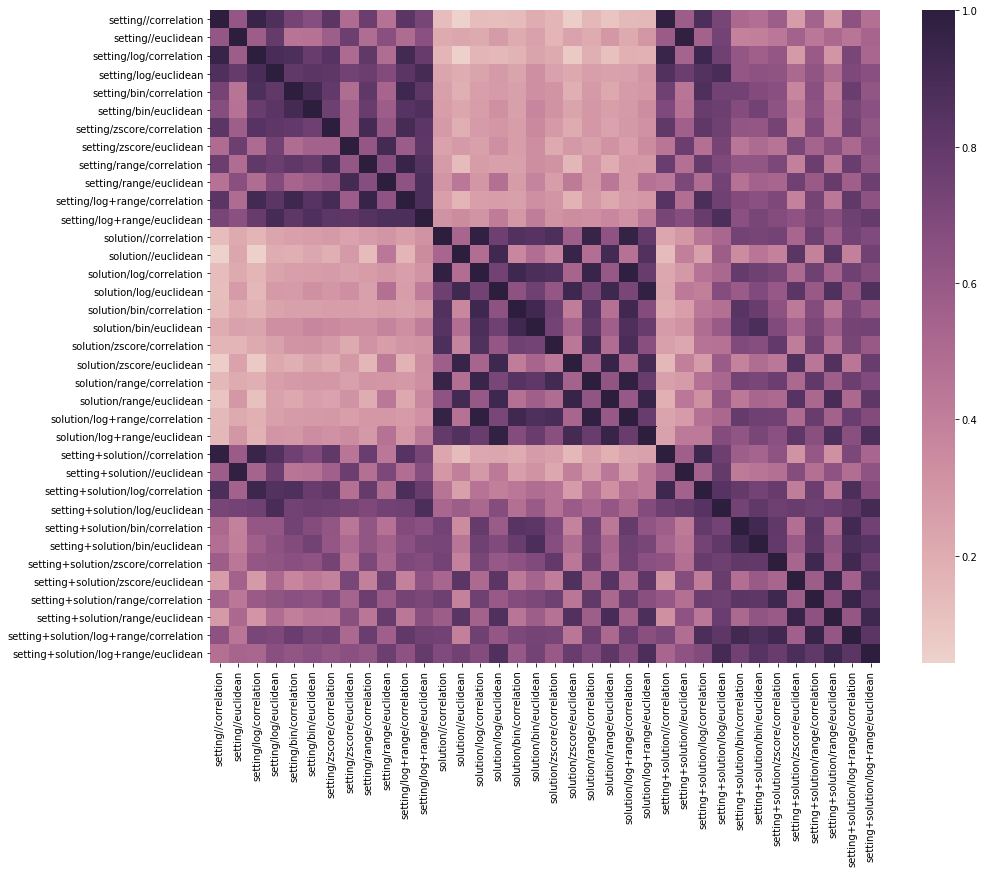

In [8]:
show_agreements_for_similarity_pipelines(total_correlation)

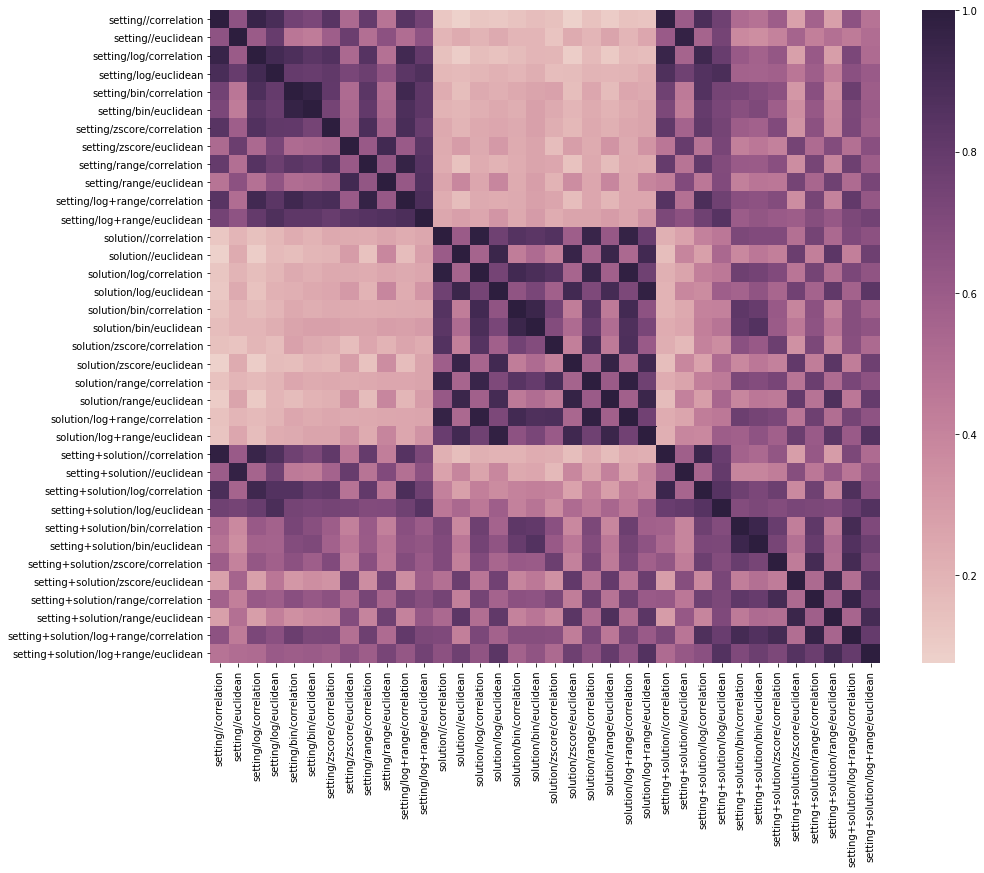

In [9]:
show_agreements_for_similarity_pipelines(partial(total_correlation, method='spearman'))

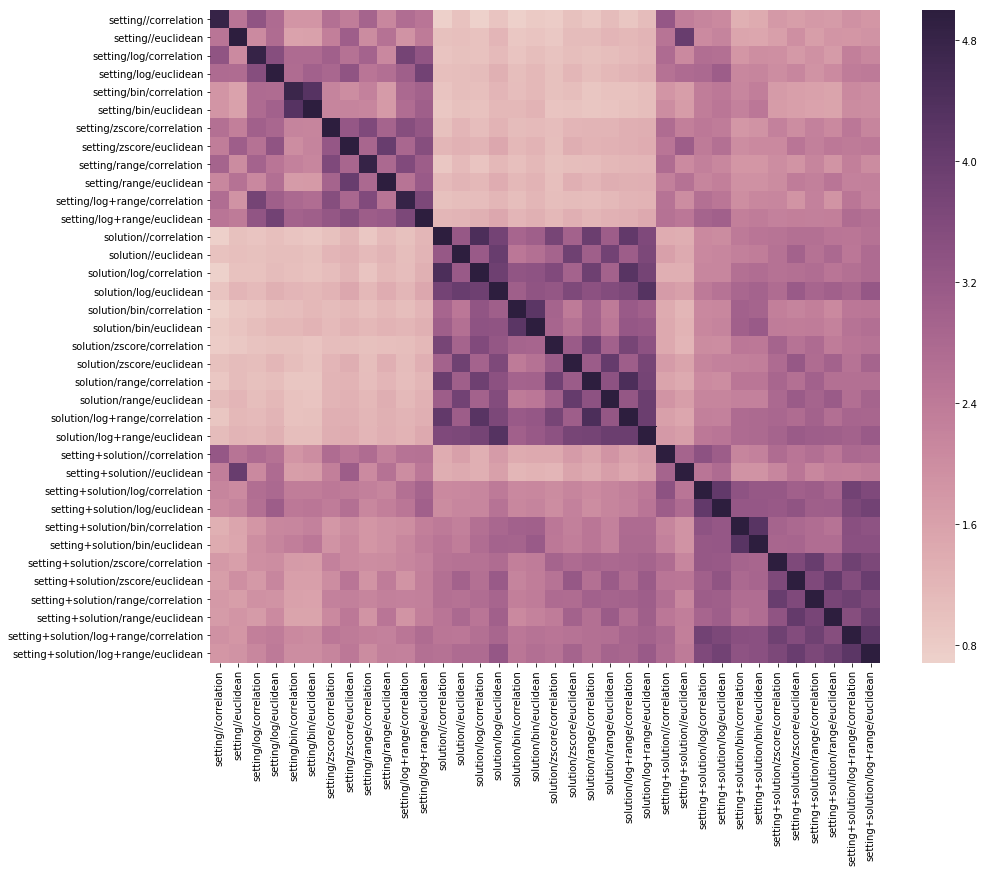

In [10]:
show_agreements_for_similarity_pipelines(partial(top_k_agreement, k=5))

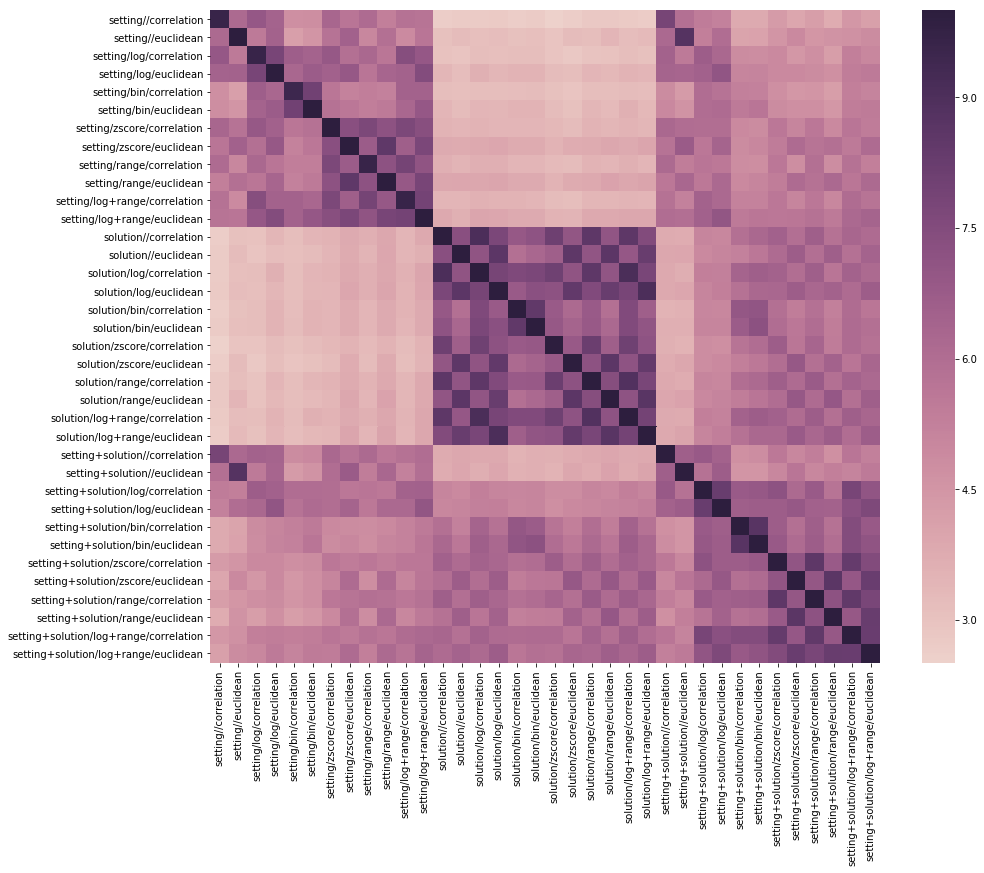

In [11]:
show_agreements_for_similarity_pipelines(partial(top_k_agreement, k=10))

Agreement heatmaps looks different depending on whether we use top-k-agreement or correlation, but it is not clear whether the differences are susbstantial. On the other hand, differences between two types of correlations, or k=5 vs k=10 in top-k-agreement are almost definitely not important.

Let's go one level of abstraction up and compute pairwise correlations between different agreement metrics.

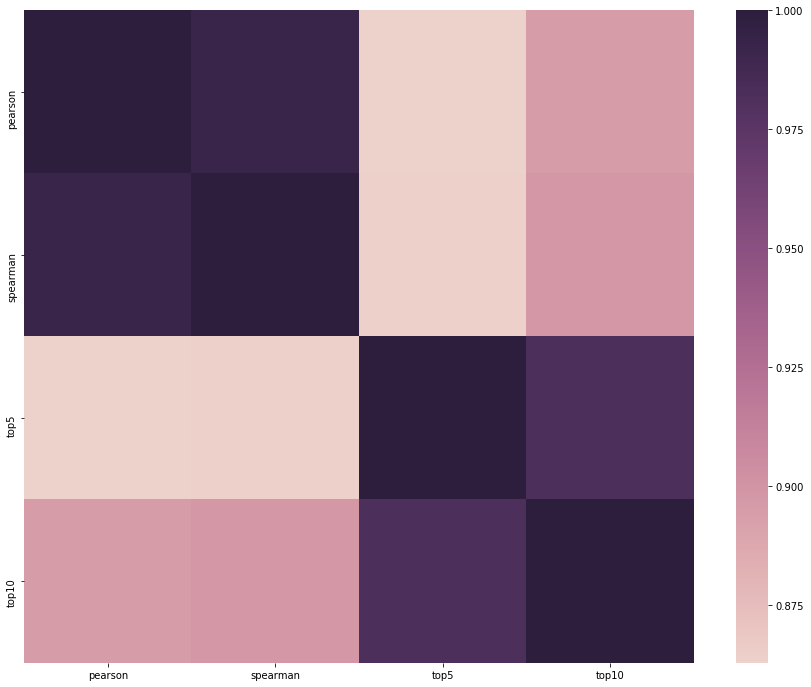

In [12]:
agreement_fns = {
    'pearson': partial(total_correlation, method='pearson'),
    'spearman': partial(total_correlation, method='spearman'),
    'top5': partial(top_k_agreement, k=5),
    'top10': partial(top_k_agreement, k=10),
}

agreement_matrices = [
    compute_agreements(similarity_matrices, agreement_fn, labels=option_names).values
    for agreement_fn in agreement_fns.values()]

show_agreement_matrix(agreement_matrices, total_correlation, labels=list(agreement_fns))

Correlations between all agreement functions are quite high (over 0.85).